In [1]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.1 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 61.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.3/414.3 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 16.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.4/253.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

In [3]:
from datasets import load_dataset

# Load the JSON file as a dataset
ds = load_dataset("json", data_files="/kaggle/input/knowledge-base/synthetic_resumes.json", split="train")

# Now you can work with the dataset
print(ds[0])  # Access the first record

Generating train split: 0 examples [00:00, ? examples/s]

{'name': 'William Reed', 'contact_info': 'jessica61@example.net', 'education': {'degree': 'B.Sc. Computer Science', 'university': 'Turner-Spencer', 'year_of_completion': 2011}, 'experience': [{'company': 'NextGen Solutions', 'description': 'Worked on various projects including AI, data analysis, and software development.', 'job_title': 'Software Engineer', 'years_of_experience': 10}], 'skills': ['Project Management', 'Team Leadership', 'Java', 'Communication', 'SQL'], 'certifications': ['Google Data Engineer']}


In [4]:
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm

RAW_KNOWLEDGE_BASE = []
for doc in tqdm(ds):
    try:
        # Combine multiple fields for a richer page_content
        page_content = (
            f"Name: {doc.get('name', 'N/A')}. "
            f"Skills: {', '.join(doc.get('skills', []))}. "
            f"Experience: {doc.get('experience', [{}])[0].get('description', 'No experience listed')}. "
            f"Education: {doc.get('education', {}).get('degree', 'No degree listed')}"
        )
        metadata = {"source": "synthetic_resumes.json"}
        RAW_KNOWLEDGE_BASE.append(LangchainDocument(page_content=page_content, metadata=metadata))
    except KeyError as e:
        print(f"Skipping document due to missing key: {e}")

100%|██████████| 100/100 [00:00<00:00, 9877.08it/s]


In [5]:
# Example: Print the first document
print(RAW_KNOWLEDGE_BASE[0].page_content)
print(RAW_KNOWLEDGE_BASE[0].metadata)

Name: William Reed. Skills: Project Management, Team Leadership, Java, Communication, SQL. Experience: Worked on various projects including AI, data analysis, and software development.. Education: B.Sc. Computer Science
{'source': 'synthetic_resumes.json'}


## EMBEDDNGS


In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [7]:
docs_processed[0]

Document(metadata={'source': 'synthetic_resumes.json', 'start_index': 0}, page_content='Name: William Reed. Skills: Project Management, Team Leadership, Java, Communication, SQL. Experience: Worked on various projects including AI, data analysis, and software development.. Education: B.Sc. Computer Science')

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


100%|██████████| 100/100 [00:00<00:00, 4441.33it/s]


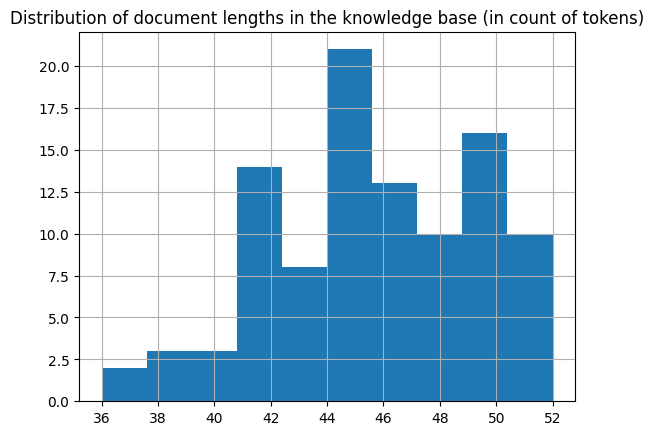

In [8]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [9]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-9-0add4c2096d7>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Chunks:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
# print(f"\nStarting retrieval for {user_query=}...")
user_query =  """Looking for a candidate with expertise in Python, Machine Learning, NLP, and SQL. 
Must have experience in building predictive models and working with large datasets."""
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


==================================Top document==================================
Name: Derek Lewis. Skills: Project Management, SQL, Communication, Machine Learning, Python, C++. Experience: Worked on various projects including AI, data analysis, and software development.. Education: M.Sc. Data Science
==================================Metadata==================================
{'source': 'synthetic_resumes.json', 'start_index': 0}


In [13]:
retrieved_docs

[Document(id='62818b77-4658-44f9-8581-cfd902fff588', metadata={'source': 'synthetic_resumes.json', 'start_index': 0}, page_content='Name: Derek Lewis. Skills: Project Management, SQL, Communication, Machine Learning, Python, C++. Experience: Worked on various projects including AI, data analysis, and software development.. Education: M.Sc. Data Science'),
 Document(id='732378ee-a2c9-4991-bffd-1ba45fa23e42', metadata={'source': 'synthetic_resumes.json', 'start_index': 0}, page_content='Name: Allison Ross. Skills: Java, SQL, Project Management, Python, Communication. Experience: Worked on various projects including AI, data analysis, and software development.. Education: M.Sc. Data Science'),
 Document(id='90e9ff2a-5189-4bbd-a16f-1e3549b607e6', metadata={'source': 'synthetic_resumes.json', 'start_index': 0}, page_content='Name: John Cooley. Skills: Python, SQL, Machine Learning, Data Analysis. Experience: Worked on various projects including AI, data analysis, and software development.. 